#### 背景说明
随着天网工程的不断完善，对固定区域进行实时监控和信息记录变得更加容易，比如在追捕嫌疑人时，可以通过车辆、体态、人脸等信息锁定嫌疑人。但在日益积累的数据中如何快速锁定嫌疑人在一定程度上也产生了负担，如何从海量信息中对嫌疑人进行定位就成了关键。本项目选取对“人脸识别”进行分析，利用机器学习的PCA和SVM算法对人脸进行分类，从而实现人脸识别功能。

#### 示例数据
本项目选取10个人的若干张人脸图像，分别存放在10个不同的文件夹中。

#### 分析思路
传统机器学习进行图像分类时会提取图像的全部特征，而本项目是对人脸进行分类，若非人脸部分（噪声部分）占比过大，会降低模型准确率。因此需要对图像进行裁剪，尽量提高人脸部分的占比。<br>
1.图像裁剪。读取personimages文件夹内所有子文件夹图片，选取最佳裁剪区域。<br>
2.分割数据集，将数据划分为训练集和测试集。<br>
3.PCA降维。图片的特征维度高，利用PCA降维。<br>
4.SVM分类。SVM进行图片分类，并做测试。



## 导库

In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

#SVM
from sklearn import svm
#PCA
from sklearn.decomposition import PCA
#数据集切分
from sklearn.model_selection import train_test_split
#评价指标：混淆矩阵、模型评估报告、准确率
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 

## 读取各个文件夹的图像

#### 每个人的图片存放在不同的文件夹下，获取文件名称

In [2]:
#获取各个文件夹的路径
path = r"./data/personimages"
dirs = os.listdir(path) #返回指定的文件夹包含的文件或文件夹的名字的列表
print(dirs) #输出所有文件夹名字

['2091145', '2127038', '2125540', '2105291', '2106637', '2088803', '2093097', '2143282', '2130586']


#### 将所有图片提取放到一起，并为图片打上标签

In [3]:
X = [] #定义图像路径
Y = [] #定义图像分类类标

#文件名为数字，不美观，重新设置名字
names = {'2088803':'person_1', '2091145':'person_2', '2093097':'person_3', '2105291':'person_4', '2106637':'person_5',
         '2125540':'person_6', '2127038':'person_7', '2130586':'person_8', '2143282':'person_9' }
#逐个读取person文件夹下的文件夹
for file in dirs:
    #print(file)
    #对路径进行拼接
    pic_dir = os.path.join(path,file) #路径拼接
    #逐个读取图片
    for i in os.listdir(pic_dir):
        #print(i)
        #对路径进行拼接
        image_dir = pic_dir + "/" + str(i)  #路径拼接
        X.append(image_dir) #添加进路径中，获得所有图片的路径
        
        # #获取图像类标即为文件夹名称
        Y.append(names[file]) #添加进类标中，获得所有类标
#print(X)
#print(Y)

## 采集人脸信息

#### 我们要提取的是人脸信息，但计算机无法识别哪些区域是人脸，需要我们手动裁取

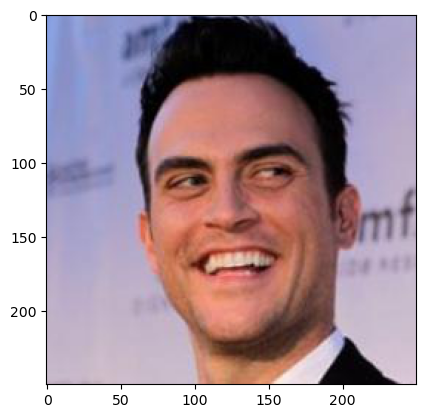

In [4]:
import matplotlib.pyplot as plt
#显示完整图片信息
img_plt = plt.imread(X[23]) #读取图片
#print(img_plt) #查看图片像素（图片由一个个像素点组成，也是数字）
plt.imshow(img_plt) #显示图片

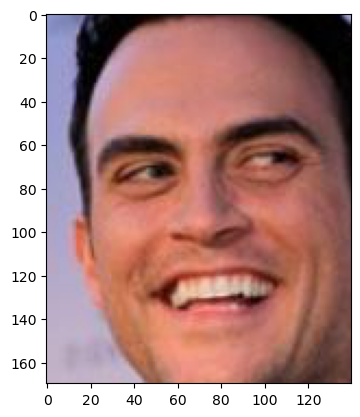

In [5]:
#不断更换图片、调整裁剪区域，得到可以获取所有人脸区域的大小
img_plt = plt.imread(X[23]) #读取图片
plt.imshow(img_plt[40:210,50:190]) #显示裁剪后的图片进行

#### 对所有图片进行裁剪，获取人脸区域图像的数据集

In [6]:
#获取人脸图像的数据集
XX = [] #定义人脸图像的数据集
#逐张读取 X 中的图片
for i in X:
    image = plt.imread(i) #读取图片
    #img = image[40:210,50:190] #进行裁剪
    img = image[40:210,50:190] #进行裁剪
    XX.append(img.flatten()) #将裁剪后的图片展平

## 分割训练集测试集

In [7]:
#选取其中的20%作为测试集，随机种子设为42
X_train, X_test, y_train, y_test = train_test_split(XX, Y,test_size=0.2,random_state=40) #切分数据集
print(len(X_train), len(X_test), len(y_train), len(y_test)) #查看一下长度

882 221 882 221


## 主成分分析PCA

用完整的数据直接训练会导致数据量过大爆内存的风险，而且没用的特征也会影响模型准确率，所以进行pca降维。
pca可以提取数据的主成分，但是经过pca降维后，我们已经不知道每个维度代表什么

In [8]:
#导入PCA模块
from sklearn.decomposition import PCA
#PCA降维
pca = PCA(n_components=50, #主成分
          svd_solver='randomized', #随机打乱
          whiten=True) #白化


pca = pca.fit(XX) #对数据进行训练，可选择整体数据或训练集数据。一般认为训练集的规模已经足够大，可以近似代表整体数据。
x_train_pca=pca.transform(X_train) #训练集数据转换

x_test_pca = pca.transform(X_test) #测试集数据转换

## 支持向量机SVM

In [9]:
# sklearn 库中导入 svm 模块
from sklearn import svm
#svm分类器
clf_svm = svm.SVC(kernel='rbf', #核函数
                  C=3,  #惩罚项
                  gamma=0.002)  #核函数的系数
# 训练分类器
clf_svm.fit(x_train_pca, y_train)  #训练分类器

SVC(C=3, gamma=0.002)

In [10]:
#对测试集进行预测
y_pre = clf_svm.predict(x_test_pca)
y_pre

array(['person_7', 'person_1', 'person_4', 'person_4', 'person_4',
       'person_1', 'person_5', 'person_1', 'person_9', 'person_4',
       'person_7', 'person_2', 'person_9', 'person_1', 'person_9',
       'person_7', 'person_3', 'person_1', 'person_3', 'person_5',
       'person_8', 'person_1', 'person_3', 'person_1', 'person_3',
       'person_5', 'person_1', 'person_5', 'person_1', 'person_1',
       'person_1', 'person_1', 'person_9', 'person_2', 'person_8',
       'person_1', 'person_1', 'person_9', 'person_4', 'person_1',
       'person_4', 'person_6', 'person_6', 'person_3', 'person_9',
       'person_5', 'person_3', 'person_1', 'person_1', 'person_4',
       'person_5', 'person_1', 'person_2', 'person_8', 'person_1',
       'person_7', 'person_3', 'person_8', 'person_7', 'person_2',
       'person_9', 'person_5', 'person_5', 'person_1', 'person_5',
       'person_9', 'person_8', 'person_3', 'person_3', 'person_5',
       'person_3', 'person_1', 'person_3', 'person_1', 'person

#### 比较训练集和测试集的准确率，防止模型过拟合

In [11]:
#模型的准确率
print("测试集准确度",accuracy_score(y_test,y_pre)) #训练集准确率
print("训练集准确度",accuracy_score(y_train,clf_svm.predict(x_train_pca))) #测试集准确率

测试集准确度 0.751131221719457
训练集准确度 0.8299319727891157


In [12]:
#看一下算法评价
print (u'算法评价:')
print (classification_report(y_test, y_pre)) #算法评价

算法评价:
              precision    recall  f1-score   support

    person_1       0.60      0.93      0.73        40
    person_2       0.67      0.62      0.65        16
    person_3       0.84      0.79      0.81        33
    person_4       0.64      0.69      0.67        13
    person_5       0.89      0.89      0.89        35
    person_6       0.87      0.76      0.81        17
    person_7       0.75      0.47      0.58        19
    person_8       0.91      0.53      0.67        19
    person_9       0.81      0.72      0.76        29

    accuracy                           0.75       221
   macro avg       0.77      0.71      0.73       221
weighted avg       0.77      0.75      0.75       221



## 混淆矩阵

真实值： Counter({'person_1': 40, 'person_5': 35, 'person_3': 33, 'person_9': 29, 'person_7': 19, 'person_8': 19, 'person_6': 17, 'person_2': 16, 'person_4': 13})
预测值： Counter({'person_1': 62, 'person_5': 35, 'person_3': 31, 'person_9': 26, 'person_2': 15, 'person_6': 15, 'person_4': 14, 'person_7': 12, 'person_8': 11})


<Axes: >

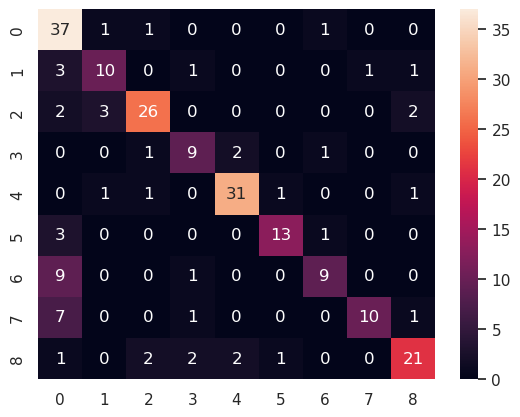

In [13]:
#进行预测
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

print("真实值：",Counter(y_test)) #真实值统计
print("预测值：",Counter(y_pre)) #预测值统计

sns.set()
confmat= confusion_matrix(y_true=y_test,y_pred=y_pre) #输出混淆矩阵
sns.heatmap(confmat,annot=True) #绘制热度图

## 验证

使用没参加过训练和测试的数据进行验证

In [14]:
path_valid = './data/validation' 
dirs_valid = os.listdir(path_valid) #返回指定的文件夹包含的文件或文件夹的名字的列表
dirs_valid #输出所有文件夹名字

['person_9.jpg',
 'person_8.jpg',
 'person_5.jpg',
 'person_4.jpg',
 'person_6.jpg',
 'person_7.jpg',
 'person_3.jpg',
 'person_2.jpg',
 'person_1.jpg']

In [15]:
#获取人脸图像的数据集
Z = [] #验证集
#逐张读取 X 中的图片
for i in dirs_valid:
    image_dir = path_valid + "/" + str(i)  #路径拼接
    image = plt.imread(image_dir) #读取图片
    img = image[40:210,50:190] #同样方式进行裁剪
    Z.append(img.flatten()) #将裁剪后的图片展平

In [16]:
valid = pca.transform(Z) #同样方式降维

In [17]:
valid_pre = clf_svm.predict(valid) #预测

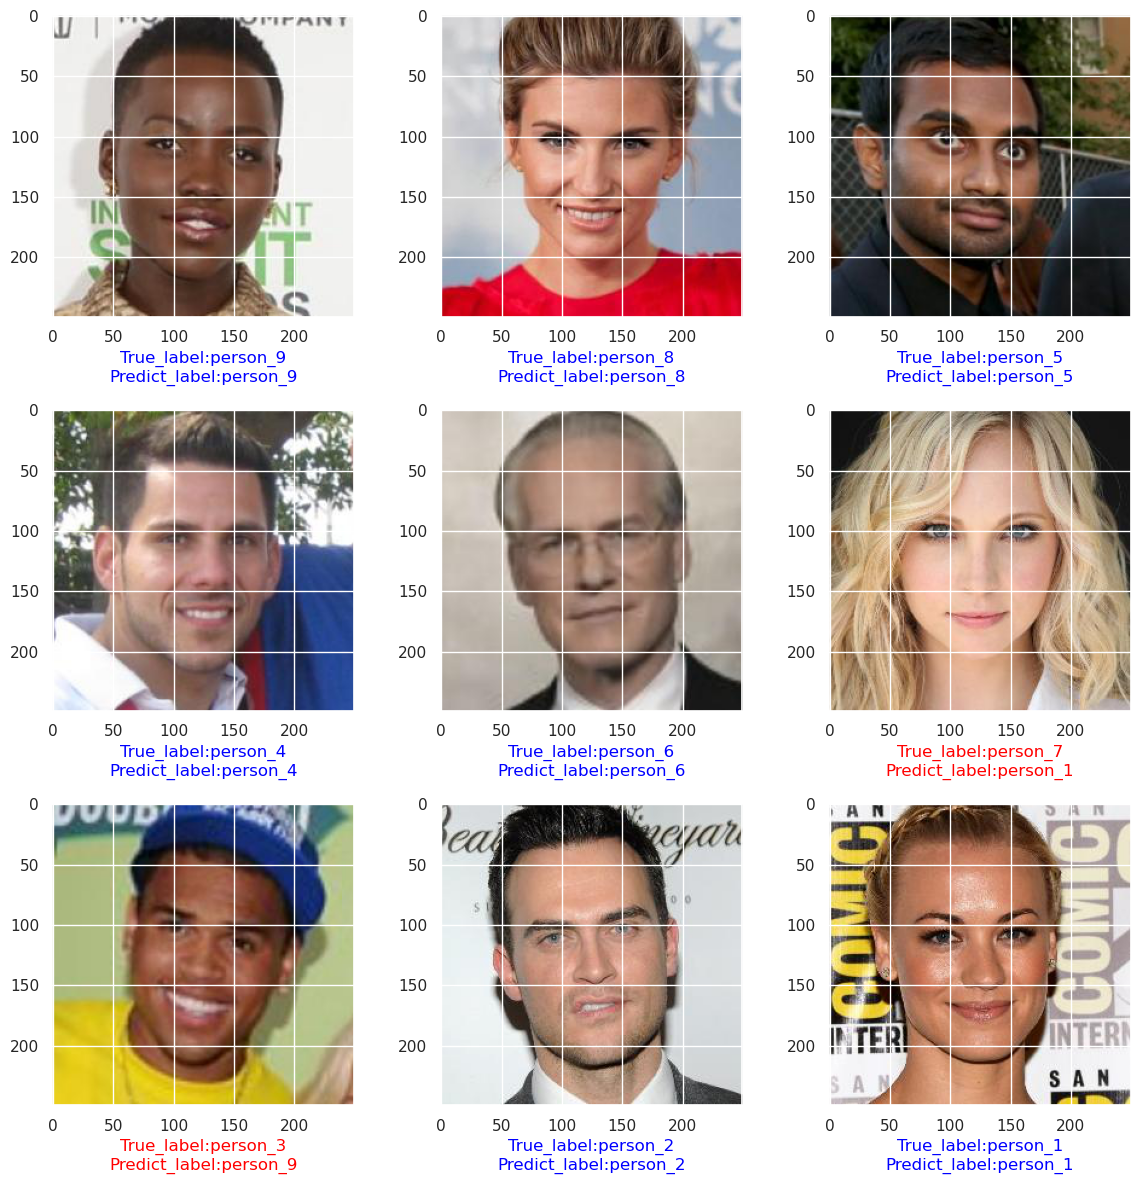

In [18]:
#可视化，展示图片，查看预测结果与真实结果的对应。
plt.figure(figsize=(12,12))
for i,j in enumerate(dirs_valid):    
    plt.subplot(3,3,i+1) #多个子图
    image_dir = path_valid + "/" + str(j)  #路径拼接
    img = plt.imread(image_dir) #读取图像
    if dirs_valid[i][:8] == valid_pre[i]:
        color = 'blue' #实际名字等于预测的名字，显示为蓝色
    else:
        color = 'red' #否则显示为红色
    #用format拼接行标签，预测结果+预测概率+正确结果
    plt.xlabel('True_label:'+dirs_valid[i][:8]+'\n'+'Predict_label:'+valid_pre[i],color=color) #x轴标签
    plt.tight_layout() #调整子图位置
    plt.imshow(img) #显示图像